In [1]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['figure.dpi'] = 300

golf_dataset = pd.read_csv("golf_dataset_mini_original_with_testset.csv")
df = golf_dataset.copy()

df

,Outlook_sunny,Outlook_overcast,Outlook_rain,Temperature,Humidity,Wind,Play
0,1,0,0,85.0,85.0,0,0
1,1,0,0,80.0,90.0,1,0
2,0,1,0,83.0,78.0,0,1
3,0,0,1,70.0,96.0,0,1
4,0,0,1,68.0,80.0,0,1
5,0,0,1,65.0,70.0,1,0
6,0,1,0,64.0,65.0,1,1
7,1,0,0,72.0,95.0,0,0
8,1,0,0,69.0,70.0,0,1
9,0,0,1,75.0,80.0,0,1


In [2]:
from sklearn.model_selection import train_test_split

df = golf_dataset.copy()

# Set feature matrix X and target vector y
X, y = df.drop('Play', axis=1), df['Play']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=False)

In [3]:
def sort_attr_label(attr, lbl):
    return (pd.concat([attr, lbl], axis=1)
            .sort_values([attr.name, lbl.name])
            .reset_index()
            .rename(columns={'index': 'ID'})
            .set_index('ID'))

print(sort_attr_label(X_train['Outlook_sunny'], y_train))
print(sort_attr_label(X_train['Temperature'], y_train))

    Outlook_sunny  Play
ID                     
5               0     0
13              0     0
2               0     1
3               0     1
4               0     1
6               0     1
9               0     1
11              0     1
12              0     1
0               1     0
1               1     0
7               1     0
8               1     1
10              1     1
    Temperature  Play
ID                   
6          64.0     1
5          65.0     0
4          68.0     1
8          69.0     1
3          70.0     1
13         71.0     0
7          72.0     0
11         72.0     1
9          75.0     1
10         75.0     1
1          80.0     0
12         81.0     1
2          83.0     1
0          85.0     0


In [4]:
def potential_split_points(attr):
    sorted_attr = np.sort(attr)
    unique_values = np.unique(sorted_attr)
    return [(unique_values[i] + unique_values[i+1]) / 2 for i in range(len(unique_values) - 1)]

print(potential_split_points(X_train['Outlook_sunny']))
print(potential_split_points(X_train['Temperature']))

[np.float64(0.5)]
[np.float64(64.5), np.float64(66.5), np.float64(68.5), np.float64(69.5), np.float64(70.5), np.float64(71.5), np.float64(73.5), np.float64(77.5), np.float64(80.5), np.float64(82.0), np.float64(84.0)]


In [5]:
from fractions import Fraction

def gini_impurity(labels):
    counts = np.unique(labels, return_counts=True)[1]
    n = len(labels)
    p = counts / n
    formula = '1 - ' + ' - '.join([f'({Fraction(c).limit_denominator()}/{n})²' for c in counts])
    gini = 1 - np.sum(p ** 2)
    return counts, sum(counts), formula, gini.round(3)

def gini_by_attribute(split_point, attr, labels):
    # Define ranges based on the split point
    low_range = f"≤ {split_point}"
    high_range = f"> {split_point}"

    # Divide data based on the split point
    low_data = labels[attr <= split_point]
    high_data = labels[attr > split_point]

    # Calculate Gini impurities for each subset
    data = [(low_range, *gini_impurity(low_data)),
            (high_range, *gini_impurity(high_data))]

    return pd.DataFrame(data, columns=['Value', 'Σ0, Σ1', 'Σ', 'Gini_Formula', 'Impurity'])

print(gini_by_attribute(0.5, X_train['Outlook_sunny'], y_train))

   Value  Σ0, Σ1  Σ         Gini_Formula  Impurity
0  ≤ 0.5  [2, 7]  9  1 - (2/9)² - (7/9)²     0.346
1  > 0.5  [3, 2]  5  1 - (3/5)² - (2/5)²     0.480


In [6]:
def potential_split_points(attr):
    sorted_attr = np.sort(attr)
    unique_values = np.unique(sorted_attr)
    return [(unique_values[i] + unique_values[i+1]) / 2 for i in range(len(unique_values) - 1)]

split_points = potential_split_points(X_train['Temperature'])

for point in split_points:
  print(f"Split Point: {point}")
  print(gini_by_attribute(point, X_train['Temperature'], y_train))
  print("\n")

Split Point: 64.5
    Value  Σ0, Σ1   Σ           Gini_Formula  Impurity
0  ≤ 64.5     [1]   1             1 - (1/1)²     0.000
1  > 64.5  [5, 8]  13  1 - (5/13)² - (8/13)²     0.473


Split Point: 66.5
    Value  Σ0, Σ1   Σ           Gini_Formula  Impurity
0  ≤ 66.5  [1, 1]   2    1 - (1/2)² - (1/2)²     0.500
1  > 66.5  [4, 8]  12  1 - (4/12)² - (8/12)²     0.444


Split Point: 68.5
    Value  Σ0, Σ1   Σ           Gini_Formula  Impurity
0  ≤ 68.5  [1, 2]   3    1 - (1/3)² - (2/3)²     0.444
1  > 68.5  [4, 7]  11  1 - (4/11)² - (7/11)²     0.463


Split Point: 69.5
    Value  Σ0, Σ1   Σ           Gini_Formula  Impurity
0  ≤ 69.5  [1, 3]   4    1 - (1/4)² - (3/4)²     0.375
1  > 69.5  [4, 6]  10  1 - (4/10)² - (6/10)²     0.480


Split Point: 70.5
    Value  Σ0, Σ1  Σ         Gini_Formula  Impurity
0  ≤ 70.5  [1, 4]  5  1 - (1/5)² - (4/5)²     0.320
1  > 70.5  [4, 5]  9  1 - (4/9)² - (5/9)²     0.494


Split Point: 71.5
    Value  Σ0, Σ1  Σ         Gini_Formula  Impurity
0  ≤ 71.5  [2,

In [7]:
def weighted_avg_gini(split_point, attr, labels):
    gini_df = gini_by_attribute(split_point, attr, labels)
    total_count = len(labels)
    weighted_ginis = [row['Σ0, Σ1'] * row['Impurity'] for _, row in gini_df.iterrows()]
    weighted_gini = sum(weighted_ginis) / total_count
    formula = ' + '.join([f'({row["Σ"]}/{total_count})*{row["Impurity"]}' for _, row in gini_df.iterrows()])

    output_df = pd.DataFrame({
        'Σ': [gini_df['Σ'].tolist()],
        'Impurity': [gini_df['Impurity'].tolist()],
        'Weighted_Gini_Formula': [formula],
        'Weighted_Gini': [sum(weighted_gini).round(3)]
    })

    return output_df

weighted_avg_gini(0.5, X_train['Outlook_sunny'], y_train)

,Σ,Impurity,Weighted_Gini_Formula,Weighted_Gini
0,"[9, 5]","[0.346, 0.48]",(9/14)*0.346 + (5/14)*0.48,0.394


In [8]:
def evaluate_splits(df, labels):
    result = []
    for attr in df.columns:
        split_points = potential_split_points(df[attr])
        for point in split_points:
            weighted_gini_df = weighted_avg_gini(point, df[attr], labels)
            result.append({
                'Attribute': attr,
                'Split_Point': point,
                'Weighted_Gini': weighted_gini_df['Weighted_Gini'].values[0]
            })
    return pd.DataFrame(result)

results_df = evaluate_splits(X_train, y_train)
results_df

,Attribute,Split_Point,Weighted_Gini
0,Outlook_sunny,0.5,0.394
1,Outlook_overcast,0.5,0.357
2,Outlook_rain,0.5,0.457
3,Temperature,64.5,0.439
4,Temperature,66.5,0.452
5,Temperature,68.5,0.459
6,Temperature,69.5,0.450
7,Temperature,70.5,0.432
8,Temperature,71.5,0.458
9,Temperature,73.5,0.458


In [9]:
sort_attr_label(X_train['Outlook_overcast'], y_train)

,Outlook_overcast,Play
ID,,
0,0,0
1,0,0
5,0,0
7,0,0
13,0,0
3,0,1
4,0,1
8,0,1
9,0,1


In [10]:
# Second iteration of training
X_train2 = X_train.drop([2, 6, 11, 12])
y_train2 = y_train.drop([2, 6, 11, 12])
results_df2 = evaluate_splits(X_train2, y_train2)
print(results_df2)
print(sort_attr_label(X_train2['Temperature'], y_train2))

        Attribute  Split_Point  Weighted_Gini
0   Outlook_sunny          0.5          0.480
1    Outlook_rain          0.5          0.480
2     Temperature         66.5          0.445
3     Temperature         68.5          0.500
4     Temperature         69.5          0.476
5     Temperature         70.5          0.416
6     Temperature         71.5          0.480
7     Temperature         73.5          0.500
8     Temperature         77.5          0.375
9     Temperature         82.5          0.445
10       Humidity         75.0          0.476
11       Humidity         82.5          0.416
12       Humidity         87.5          0.476
13       Humidity         92.5          0.500
14       Humidity         95.5          0.445
15           Wind          0.5          0.416
    Temperature  Play
ID                   
5          65.0     0
4          68.0     1
8          69.0     1
3          70.0     1
13         71.0     0
7          72.0     0
9          75.0     1
10         75.0     

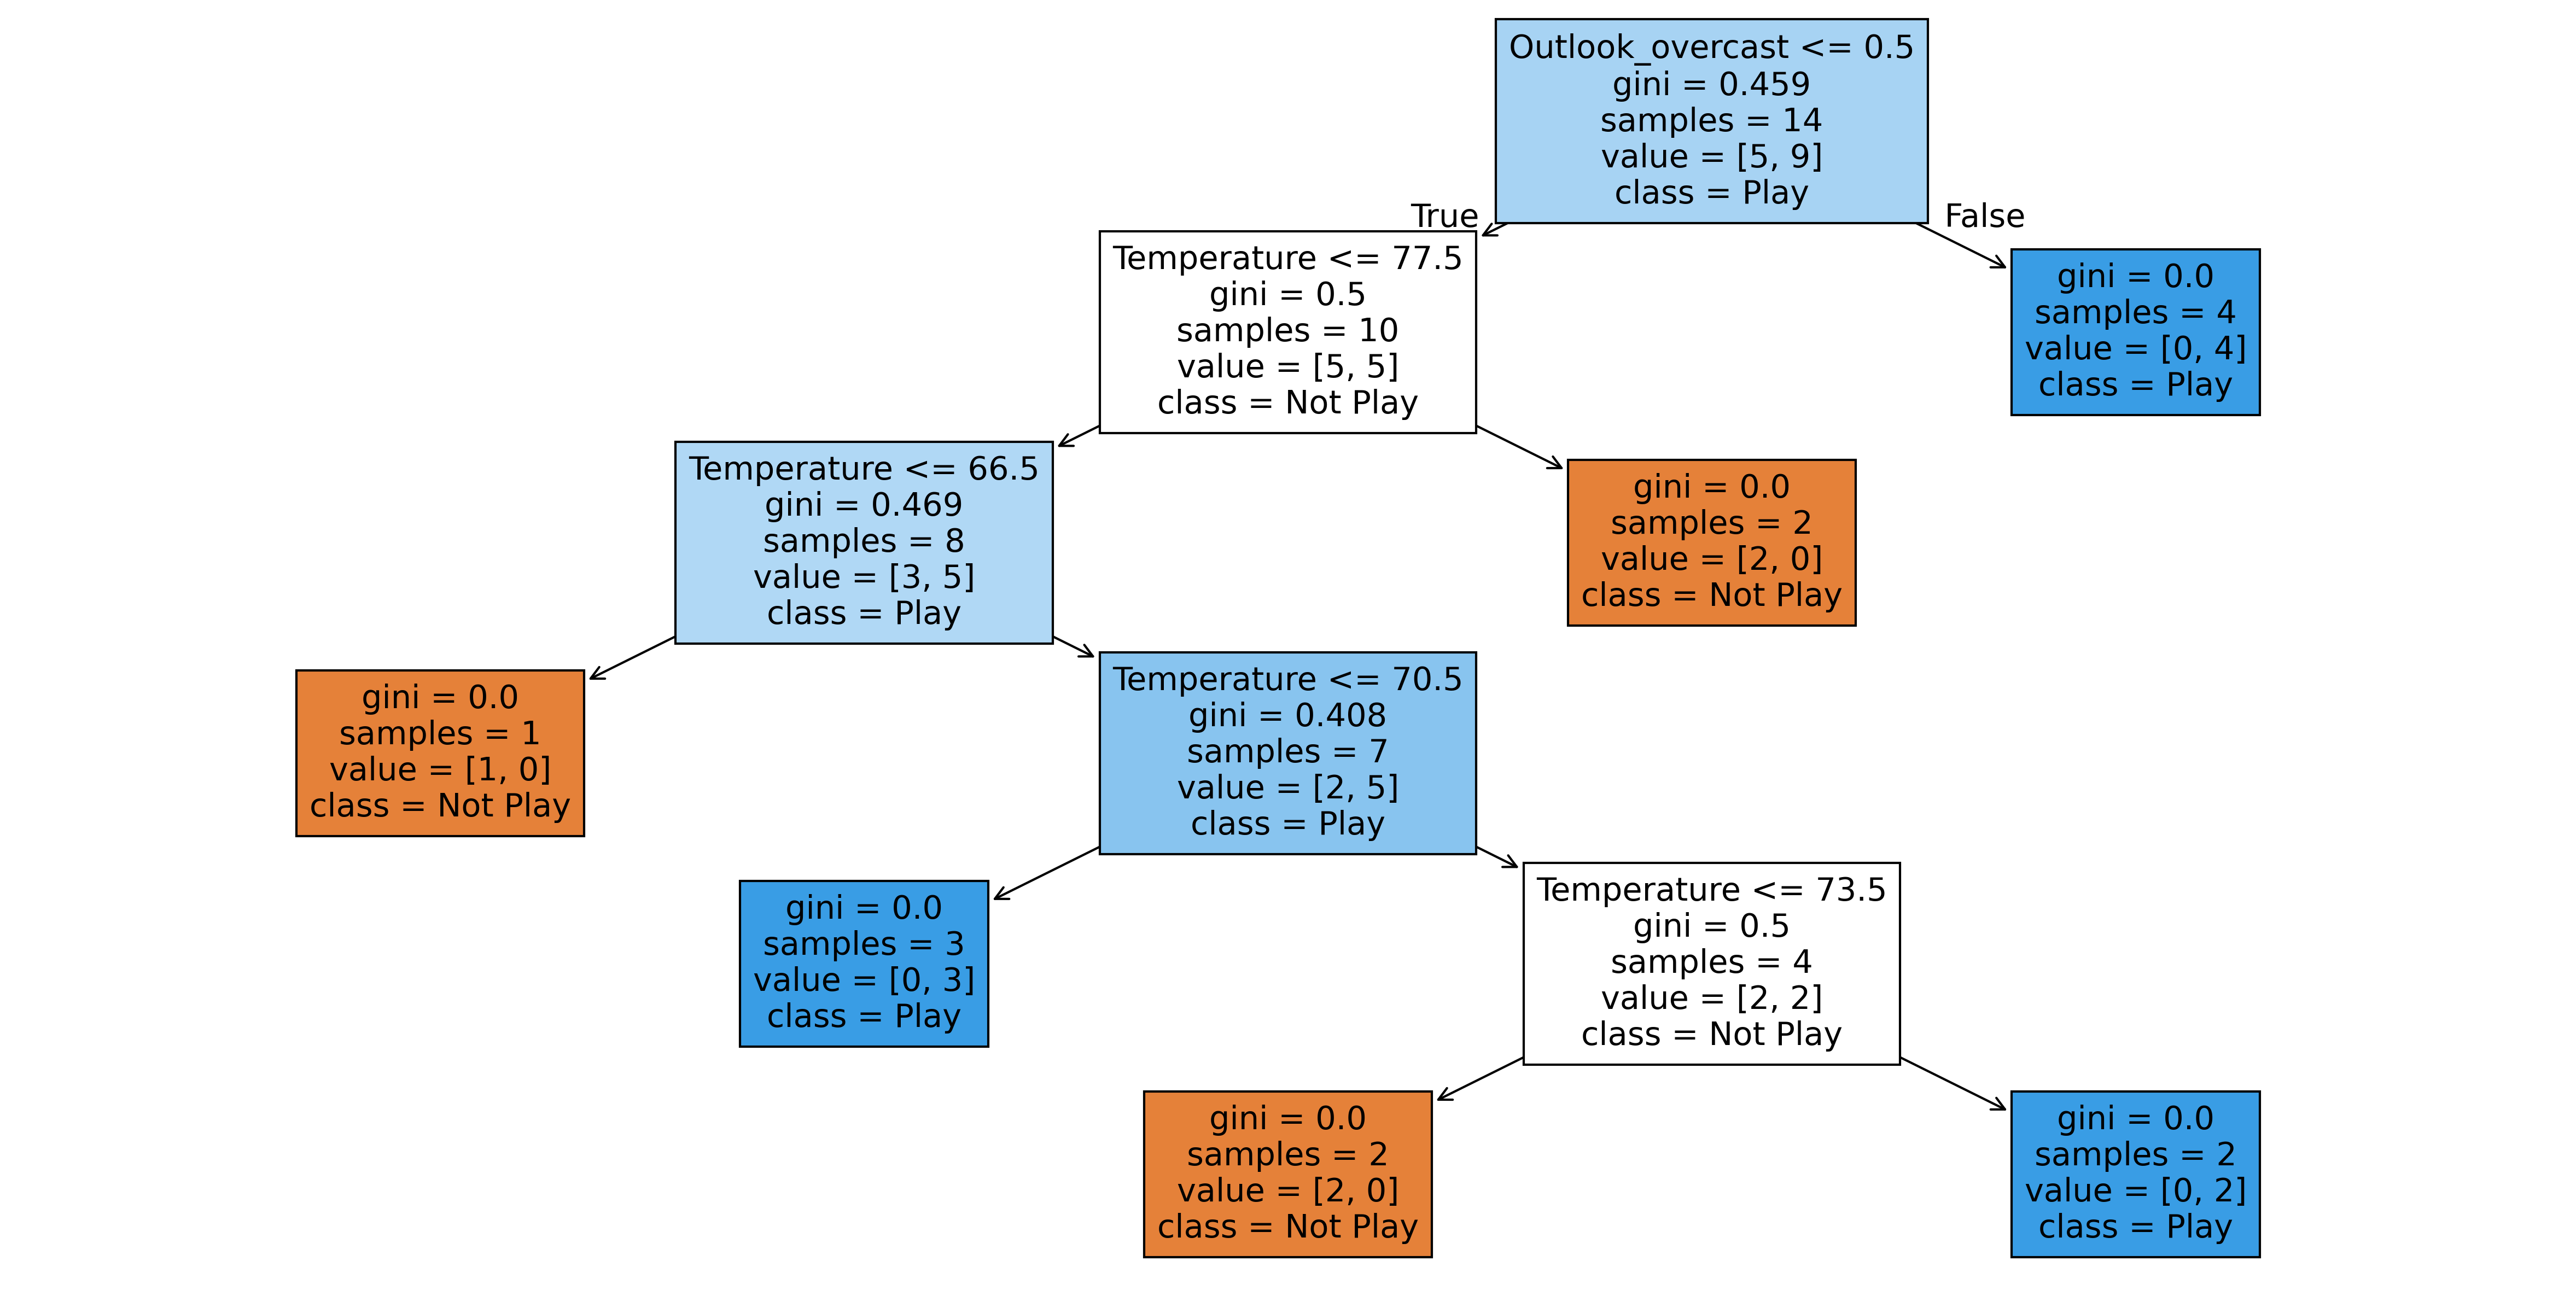

In [11]:
from sklearn.tree import DecisionTreeClassifier

# The whole Training Phase above is done inside sklearn like this
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_clf, filled=True, feature_names=X.columns, class_names=['Not Play', 'Play'])
plt.show()

In [12]:
# Make predictions
y_pred = dt_clf.predict(X_test)
print(y_pred)

[0 1 1 0 0 1 1 0 0 1 0 1 0 1]


In [13]:
# Evaluate the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7142857142857143


In [15]:
labels, predictions, accuracies = list(y_test), [], []

k_list = [2, 3, 4, 5]
for k in k_list:
    dt_clf = DecisionTreeClassifier(max_depth=k)
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    predictions.append(list(y_pred))
    accuracies.append(round(accuracy_score(y_test, y_pred) * 100, 4))
df_predictions = pd.DataFrame({'Label': labels})
for k, pred in zip(k_list, predictions):
    df_predictions[f'Depth_{k}'] = pred

df_accuracies = pd.DataFrame({'Accuracy ': accuracies}, index=[f'Depth_{k}' for k in k_list]).T

print(df_predictions)
print(df_accuracies)

    Label  Depth_2  Depth_3  Depth_4  Depth_5
0       0        0        0        0        0
1       1        1        1        1        1
2       1        1        1        0        1
3       0        0        0        0        0
4       0        0        0        0        0
5       0        1        1        1        1
6       1        1        1        1        1
7       1        1        1        0        0
8       1        0        0        0        0
9       1        1        1        1        1
10      1        0        0        0        0
11      1        1        1        1        1
12      0        1        0        0        0
13      1        1        1        1        1
           Depth_2  Depth_3  Depth_4  Depth_5
Accuracy   71.4286  78.5714  64.2857  71.4286


In [16]:
# Initialize lists
labels, predictions, accuracies = list(y_test), [], []

# Loop through different min samples split
k_list = [9, 8, 5, 2]
for k in k_list:
    dt_clf = DecisionTreeClassifier(min_samples_split=k)
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    predictions.append(list(y_pred))
    accuracies.append(round(accuracy_score(y_test, y_pred) * 100, 4))

# Create DataFrames
df_predictions = pd.DataFrame({'Label': labels})
for k, pred in zip(k_list, predictions):
    df_predictions[f'MinSplit_{k}'] = pred

df_accuracies = pd.DataFrame({'Accuracy ': accuracies}, index=[f'MinSplit_{k}' for k in k_list]).T

print(df_predictions)
print(df_accuracies)

    Label  MinSplit_9  MinSplit_8  MinSplit_5  MinSplit_2
0       0           0           0           0           0
1       1           1           1           1           1
2       1           1           1           0           1
3       0           0           0           0           0
4       0           0           0           0           0
5       0           1           1           1           1
6       1           1           1           1           1
7       1           1           1           0           0
8       1           0           0           0           0
9       1           1           1           1           1
10      1           0           0           0           0
11      1           1           1           1           1
12      0           1           0           0           0
13      1           1           1           1           1
           MinSplit_9  MinSplit_8  MinSplit_5  MinSplit_2
Accuracy      71.4286     78.5714     64.2857     71.4286


In [17]:
# Initialize lists
labels, predictions, accuracies = list(y_test), [], []

# Loop through different criterion
criterions = ['gini','entropy']
for measure in criterions:
    dt_clf = DecisionTreeClassifier(criterion=measure)
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    predictions.append(list(y_pred))
    accuracies.append(round(accuracy_score(y_test, y_pred) * 100, 4))

# Create DataFrames
df_predictions = pd.DataFrame({'Label': labels})
for k, pred in zip(criterions, predictions):
    df_predictions[f'Measure_{k}'] = pred

df_accuracies = pd.DataFrame({'Accuracy ': accuracies}, index=[f'Measure_{k}' for k in criterions]).T

print(df_predictions)
print(df_accuracies)

    Label  Measure_gini  Measure_entropy
0       0             0                0
1       1             1                1
2       1             1                1
3       0             0                0
4       0             0                0
5       0             1                0
6       1             1                1
7       1             0                0
8       1             0                0
9       1             1                1
10      1             0                0
11      1             1                1
12      0             0                1
13      1             1                1
           Measure_gini  Measure_entropy
Accuracy        71.4286          71.4286


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X, y = df.drop('Play', axis=1), df['Play']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=False)

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7142857142857143


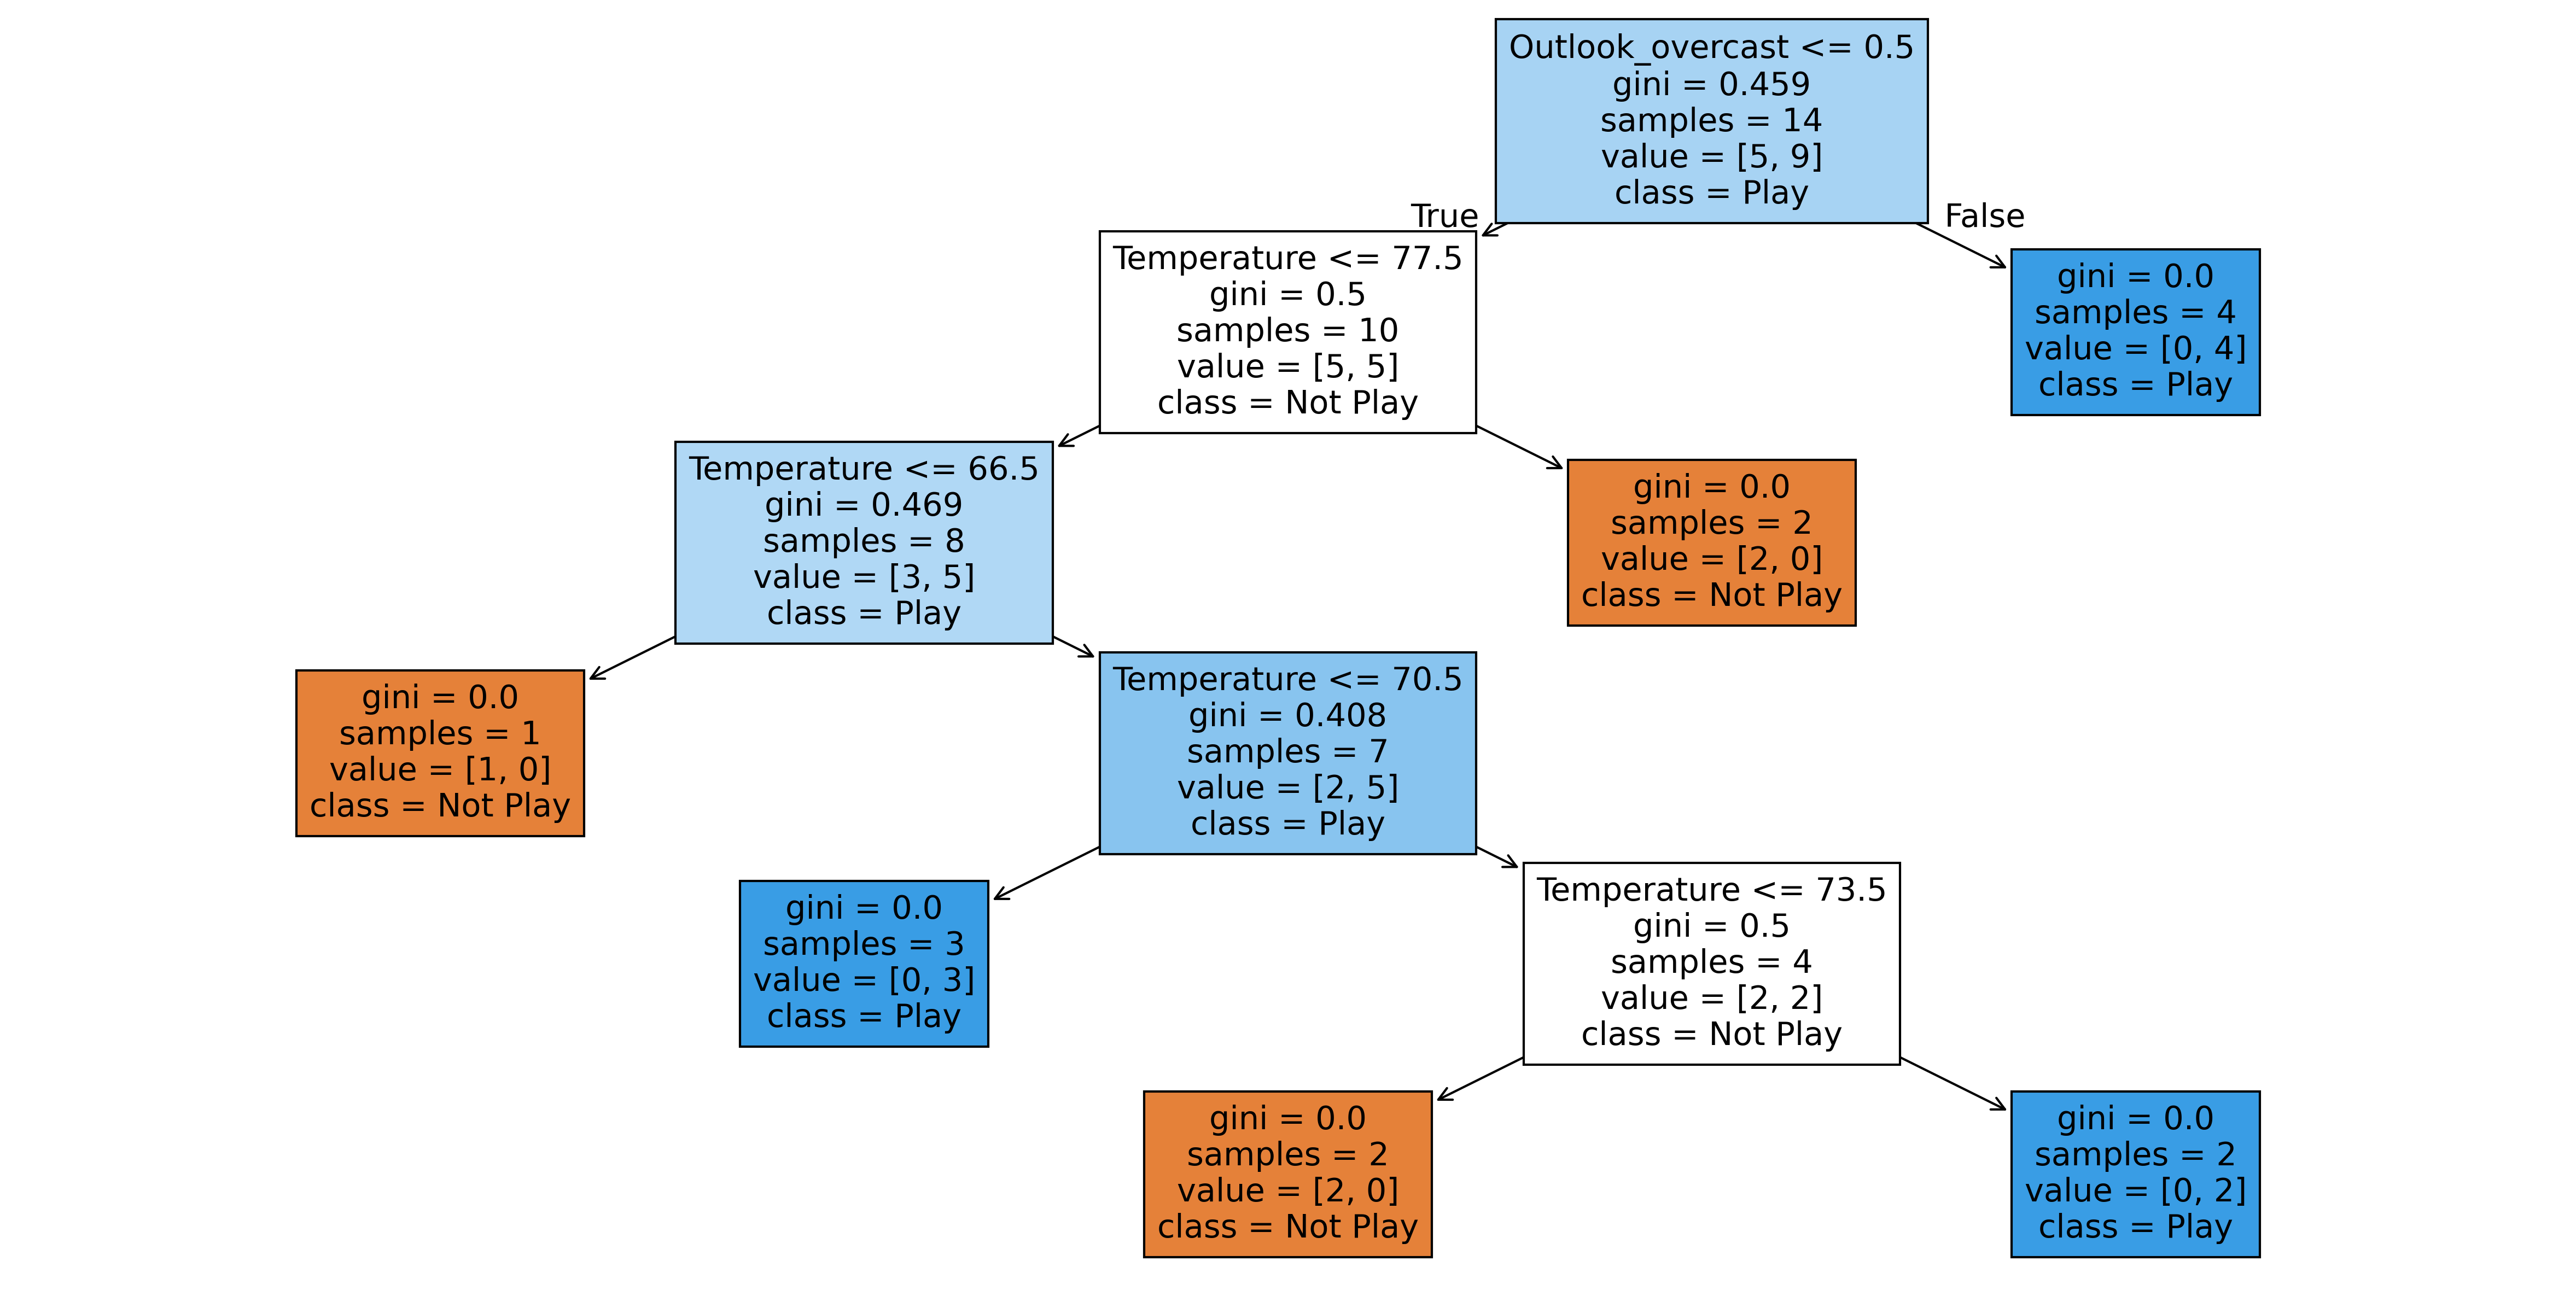

In [19]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_clf, filled=True, feature_names=X.columns, class_names=['Not Play', 'Play'])
plt.show()